# Warmup: spot detection with napari


### Overview
In this activity, we will perform spot detection on some in situ sequencing data ([Feldman and Singh et al., Cell, 2019](https://www.cell.com/cell/fulltext/S0092-8674(19)31067-0s)). The goal is to familiarize you with performing analysis that integrates the scientific python ecosystem and napari.

### Data source

The data were downloaded from the [OpticalPooledScreens github repository](https://github.com/feldman4/OpticalPooledScreens).

### Next steps

Following this activity, we will use the workflow generated in this activity to create a napari spot detection plugin. 

# Set up the notebook

Before running our analysis, we first need to configure the notebook to use the Qt backend (napari uses Qt as its GUI framework). To do so, run the cell below. You will need to do this each time you want to run napari from a Jupyter Notebook.

In [1]:
%gui qt

### screenshots
For the solution notebook, we are including screenshots via the `nbscreenshot` utility. These are not required for your notebook.

An example usage: `nbscreenshot(viewer)`

In [46]:
from napari.utils import nbscreenshot

# Load the data

In the cells below load the data using the scikit-image `imread()` function. For more information about the `imread()` function, please see the [scikit-image docs](https://scikit-image.org/docs/dev/api/skimage.io.html#skimage.io.imread). We are loading two images:

- `nuclei`: an image of cell nuclei
- `spots`: an image of in situ sequencing spots

In [2]:
from skimage import io

nuclei = io.imread('./data/nuclei_cropped.tif')
spots = io.imread('./data/spots_cropped.tif')

# View the data

We will use napari to view our data. To do so, we first must create the viewer. Once the Viewer is created, we can add images to the viewer via the Viewer's `add_image()` method. 

In [12]:
import napari

# create the napari viewer
viewer = napari.Viewer();

# add the nuclei image to the viewer
viewer.add_image(nuclei);


In the cell below, add the spots image to the viewer as was done above for the nuclei image. After loading the data, inspect it in the viewer and adjust the layer settings to your liking (e.g., contrast limits, colormap). You can pan/zoom around the image by click/dragging to pan and scrolling with your mousewheel or trackpad to zoom.

In [13]:
# add the spots image to the viewer
viewer.add_image(spots)


<Image layer 'spots' at 0x7fbca95cd040>

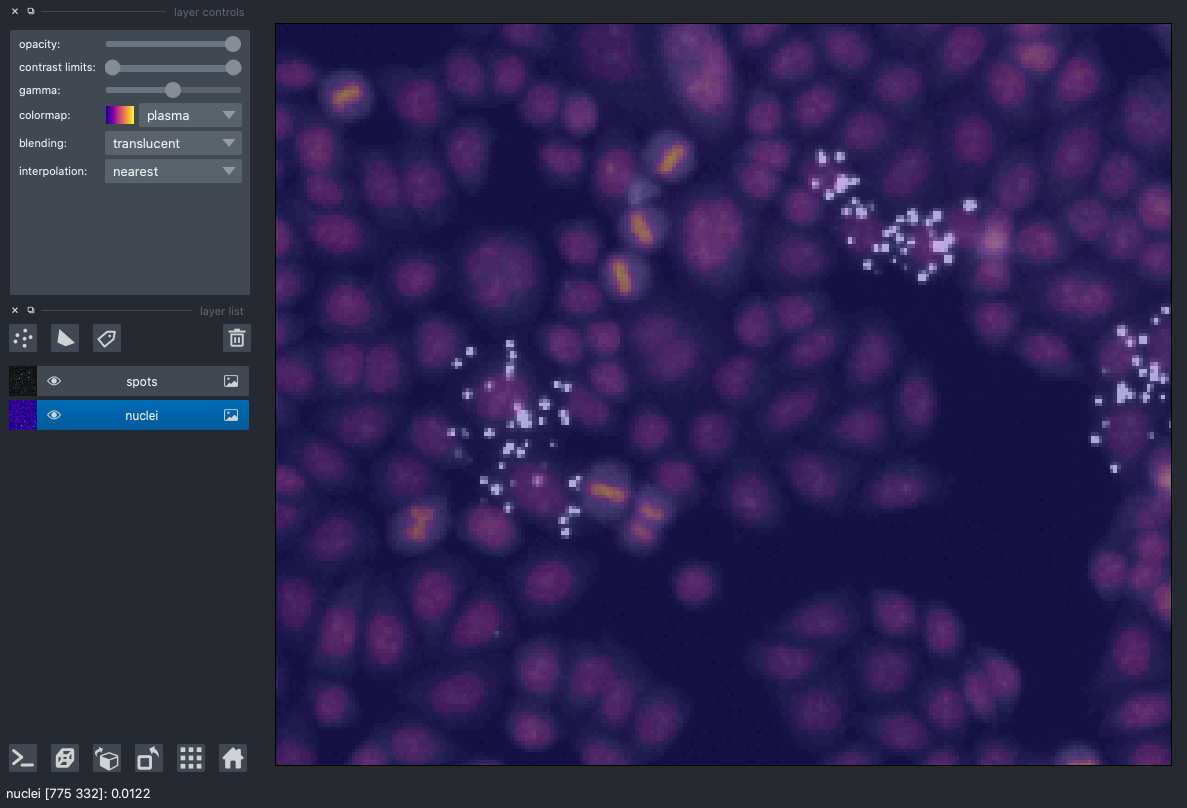

In [6]:
from napari.utils import nbscreenshot

nbscreenshot(viewer)

# Create an image filter

You may have noticed the the spots image contains background and autofluorescence from the cells. To improve spot detection, we will apply a high pass filter to improve the contrast of the spots.

In [14]:
import numpy as np
from scipy import ndimage as ndi

def gaussian_high_pass(image: np.ndarray, sigma: float = 2):
    """Apply a gaussian high pass filter to an image.

    Parameters
    ----------
    image : np.ndarray
        The image to be filtered.
    sigma : float
        The sigma (width) of the gaussian filter to be applied.
        The default value is 2.
    
    Returns
    -------
    high_passed_im : np.ndarray
        The image with the high pass filter applied
    """
    low_pass = ndi.gaussian_filter(image, sigma)
    high_passed_im = image - low_pass
    
    return high_passed_im

In the cell below, apply the gaussian high pass filter to the `spots` image and add the image to the viewer.

In [16]:
# Use the gaussian_high_pass function to filter the spots image
filtered_spots = gaussian_high_pass(spots, 2)

# add the filtered image to the viewer
# hint: set the opacity < 1 in order to see the layers underneath
viewer.add_image(filtered_spots, opacity=0.6)

<Image layer 'filtered_spots [1]' at 0x7fbcaba8e9a0>

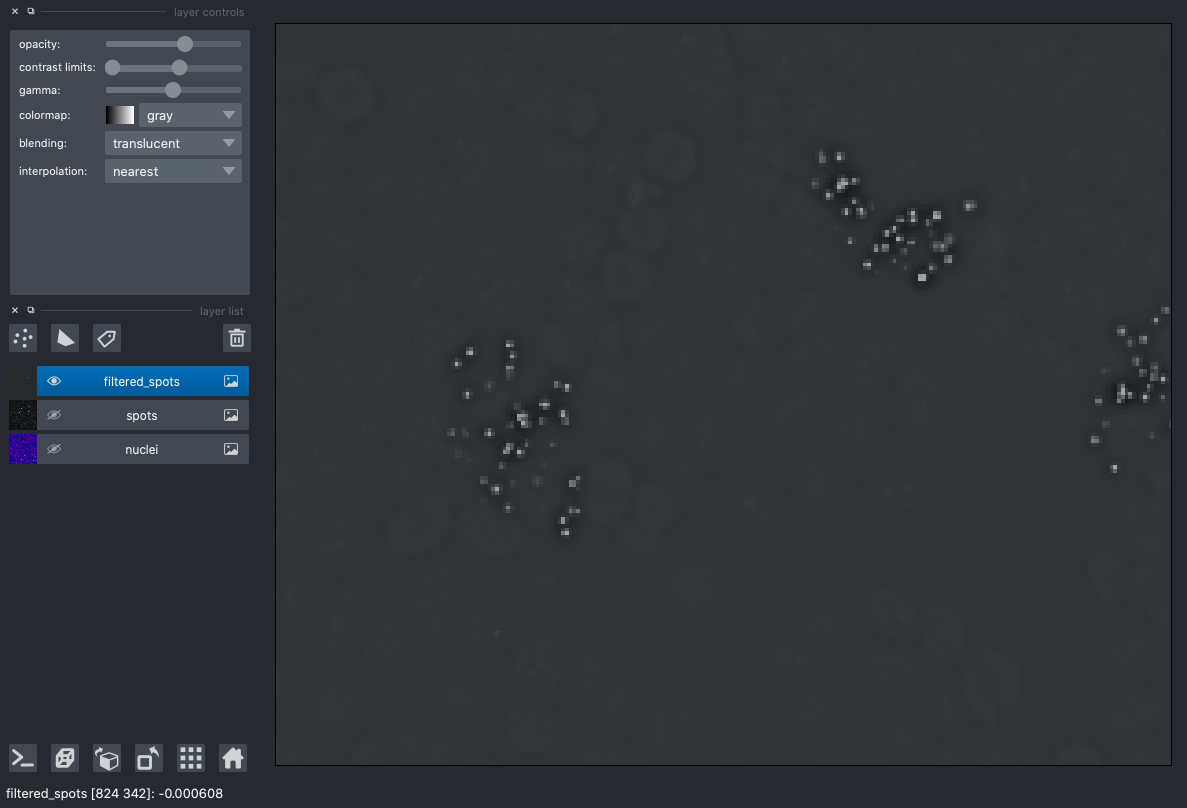

In [11]:
nbscreenshot(viewer)

# Detect spots

Next, we will create a function to detect the spots in the spot image. This function should take the raw image, apply the gaussian high pass filter from above and then use one of the blob detection algorithms from sci-kit image to perform the blob detection. The `detect_spots()` function should return a numpy array containing the coordinates of each spot and a numpy array containing the diameter of each spot.

Some hints:
- See the [blob detection tutorial from scikit-image](https://scikit-image.org/docs/dev/auto_examples/features_detection/plot_blob.html). - We recommend the [blob_log detector](https://scikit-image.org/docs/dev/api/skimage.feature.html#skimage.feature.blob_log), but feel free to experiment!
- See the "Note" from the blob_log docs: "The radius of each blob is approximately $\sqrt{2}\sigma$ for a 2-D image"

In [17]:
import numpy as np
from skimage.feature import blob_log

def detect_spots(
    image: np.ndarray,
    high_pass_sigma: float = 2,
    spot_threshold: float = 0.01,
    blob_sigma: float = 2
):
    """Apply a gaussian high pass filter to an image.

    Parameters
    ----------
    image : np.ndarray
        The image in which to detect the spots.
    high_pass_sigma : float
        The sigma (width) of the gaussian filter to be applied.
        The default value is 2.
    spot_threshold : float
        The threshold to be passed to the blob detector.
        The default value is 0.01.
    blob_sigma: float
        The expected sigma (width) of the spots. This parameter
        is passed to the "max_sigma" parameter of the blob
        detector.
    
    Returns
    -------
    points_coords : np.ndarray
        An NxD array with the coordinate for each detected spot.
        N is the number of spots and D is the number of dimensions.
    sizes : np.ndarray
        An array of size N, where N is the number of detected spots
        with the diameter of each spot.
    
    """
    # filter the image
    filtered_spots = gaussian_high_pass(image, high_pass_sigma)

    # detect the spots on the filtered image
    blobs_log = blob_log(
        filtered_spots,
        max_sigma=blob_sigma,
        num_sigma=1,
        threshold=spot_threshold
    )
    
    # convert the output of the blob detector to the 
    # desired points_coords and sizes arrays
    # (see the docstring for details)
    points_coords = blobs_log[:, 0:2]
    sizes = 3 * blobs_log[:, 2]

    return points_coords, sizes

In the cell below, we apply `detect_spots()` to our `spots` image. To visualize the results, we add the spots to the viewer as a [Points layer](https://napari.org/tutorials/fundamentals/points.html).

To test out your function, vary the detection parameters and see how they affect the results. Note that each time you run the cell, the new results are added as an addition Points layer, allowing you to compare results from different parameters.

In [18]:
# detect the spots
spot_coords, spot_sizes = detect_spots(
    spots,
    high_pass_sigma=2,
    spot_threshold=0.01,
    blob_sigma=2
)

# add the detected spots to the viewer as a Points layer
viewer.add_points(spot_coords, size=spot_sizes, symbol='ring')

<Points layer 'spot_coords' at 0x7fbcababa100>

2021-06-22 12:03:18,194 [INFO] No OpenGL_accelerate module loaded: No module named 'OpenGL_accelerate'
2021-06-22 12:03:43,105 [INFO] computed diameter = 10.462872338160567
2021-06-22 12:03:53,599 [INFO] nuclei
2021-06-22 12:03:53,601 [INFO] spots
2021-06-22 12:03:53,604 [INFO] filtered_spots
2021-06-22 12:03:53,608 [INFO] spot_coords
2021-06-22 12:03:53,611 [INFO] Shapes
(492, 494)
2021-06-22 12:03:53,627 [INFO] computing masks with cellprob_threshold=0.0, flow_threshold=0.4
2021-06-22 12:03:53,628 [INFO] >>nuclei<< model set to be used
2021-06-22 12:03:53,634 [INFO] TORCH CUDA version not installed/working.
2021-06-22 12:03:53,639 [INFO] >>>> using CPU


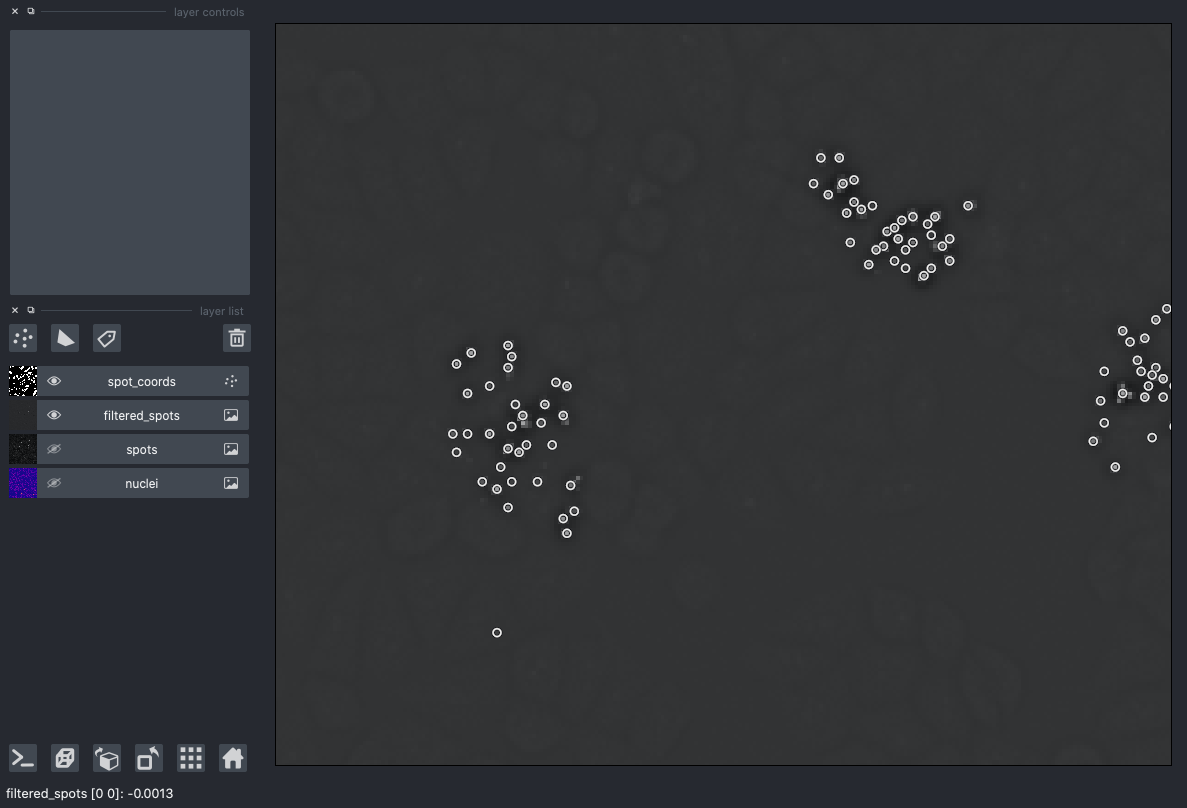

2021-06-14 17:50:39,216 [INFO] No OpenGL_accelerate module loaded: No module named 'OpenGL_accelerate'
2021-06-14 17:50:46,548 [INFO] computed diameter = 10.041963861706277
2021-06-14 17:50:56,817 [INFO] nuclei
2021-06-14 17:50:56,818 [INFO] spots
2021-06-14 17:50:56,819 [INFO] filtered_spots
2021-06-14 17:50:56,821 [INFO] spot_coords
2021-06-14 17:50:56,822 [INFO] Shapes
(1024, 1024)
2021-06-14 17:50:56,835 [INFO] computing masks with cellprob_threshold=0.0, flow_threshold=0.4
2021-06-14 17:50:56,836 [INFO] >>nuclei<< model set to be used
2021-06-14 17:50:56,837 [INFO] TORCH CUDA version not installed/working.
2021-06-14 17:50:56,838 [INFO] >>>> using CPU


In [14]:
nbscreenshot(viewer)

# Segment nuclei

To segment the nuclei, we will use the [cellpose napari plugin](https://github.com/MouseLand/cellpose-napari). Through this and the following section, we will see how one can integrate plugins developed both others into their analysis workflow. Please perform the segmentation using the instructions below. For 
more information on cellpose, please see the [paper](https://www.nature.com/articles/s41592-020-01018-x) and [repository](https://github.com/MouseLand/cellpose).

1. Start the cellpose plugin. From the menu bar, click Plugins->cellpose-napari: cellpose. You should see the plugin added to the right side of the viewer.
<img src="./resources/cellpose_plugin.png">
2. Select the "nuclei" image layer. 
<img src="./resources/cellpose_screenshots_image_selection.png">
3. Set the model type to "nuclei"
<img src="./resources/cellpose_screenshots_model_selection.png">
4. We need to give cellpose an estimate of the size of the nuclei so it can properly scale the data. We can do so using a napari Shapes layer. With the Shapes layer, we will outline some nuclei and then cellpose will use those annotations to estimate the size of the nuclei.
    1. Click the "add Shapes" layer button in the viewer. This will create and select a new layer called "Shapes".
    <img src="./resources/cellpose_screenshots_add_shape.png">
    2. Set the mode to "Ellipse" by clicking the button in the layer controls.
    3. In the canvas, click and drag to add an ellipse that around 2 "representative" nuclei. For the purpose of this demo, this is enough, but for other data you may need to give more examples to make a better estimate. If you need to pan/zoom while adding an ellipse, holding the spacebar will allow you to pan/zoom using your mouse (pan via click/drag, zoom by scrolling).
    4. If you would like to edit or move an ellipse, you can switch to "Select shapes" mode in the viewer. Shapes can now be moved by clicking on them and then dragging. They can be resized by selecting them and then dragging the control points.
    <img src="./resources/cellpose_screenshots_select_shape.png">
    5. Once you are happy with your annotations, you can click the "compute diameter from shape layer" button and you will see the "diameter" value populated. For this demo, the value is typically around 10 pixels.
    <img src="./resources/cellpose_screenshots_diameter.png">
5. For this demo, we recommend de-selecting "average 4 nets"(potentially less accurate, but faster segmentation) and otherwise using the default settings. If you would like to learn more about the cellpose settings, please see the [cellpose plugin documentation](https://cellpose-napari.readthedocs.io/en/latest/settings.html).
<img src="./resources/cellpose_screenshots_settings.png">
6. Now you are ready to run the segmentation! Click the "run segmentation" button. Segmentation for this demo typically takes ~1 minute.
<img src="./resources/cellpose_screenshots_run.png">
7. When the segmentation is completed, you will see some new layers added to the layer list. Of particular interest is "nuclei_cp_masks_000", which contains our segmentation mask added as a Labels layer.
<img src="./resources/cellpose_screenshots_results.png">



# Assign detected spots to cells

In this step, we will assign the detected spots to the nearest nucleus since as a proxy for assigning detected spots to cells.


### Step 1: get the locations of the nuclei
As we saw at the end of the cellpose section above, the segmentations are stored in the Labels layer called `nuclei_cp_masks_000`. In the labels image, each each nucleus is given a unique integer label. We can access the label image from viewer as shown below.

The Viewer object has a property calls `layers`, which is the `LayersList`. As the name suggests, the `Viewer.layers` contains each layer that is being displayed in the viewer and the layers can be accessed by their name. From the Labels layer object (called `nuclei_labels_layer` below), we can then access label image from the `data` property (stored as `nuclei_labels` below).

In [19]:
# get the nuclei masks from the output of cellpose
nuclei_labels_layer = viewer.layers['nuclei_cp_masks_000']
nuclei_labels = nuclei_labels_layer.data

Now that we have the label image for the segmented nuclei, we can determine the centroid for each nucleus. First, use regionprops_table to find the centroids of all detected nuclei. Then, create an N x 2 numpy array containing the coordinate of the centroid of each nucleus. You can visualize the coordinates in a Points layer to verify they are correct.

For more details on the regionprops_table see the scikit-image [docs](https://scikit-image.org/docs/dev/api/skimage.measure.html#skimage.measure.regionprops_table) and [examples](https://scikit-image.org/docs/stable/auto_examples/segmentation/plot_regionprops.html).

In [20]:
from skimage.measure import regionprops_table

# create a regionprops table from the nuclei_labels
# containing the label values and the centroids
# of the nuclei
rp_table = regionprops_table(
    nuclei_labels,
    properties=('label', 'centroid')
)

# create a numpy array containing the coordinates
# of the centroids of the nuclei. Each row should
# correspond to a nucleus and the columns should be
# for 
nuclei_centroids = np.column_stack(
    (rp_table['centroid-0'], rp_table['centroid-1'])
)


In the cell below, add the nuclei centroids to the viewer as a Points layer.

In [21]:
viewer.add_points(nuclei_centroids, size=5)

<Points layer 'nuclei_centroids' at 0x7fbbeb661730>

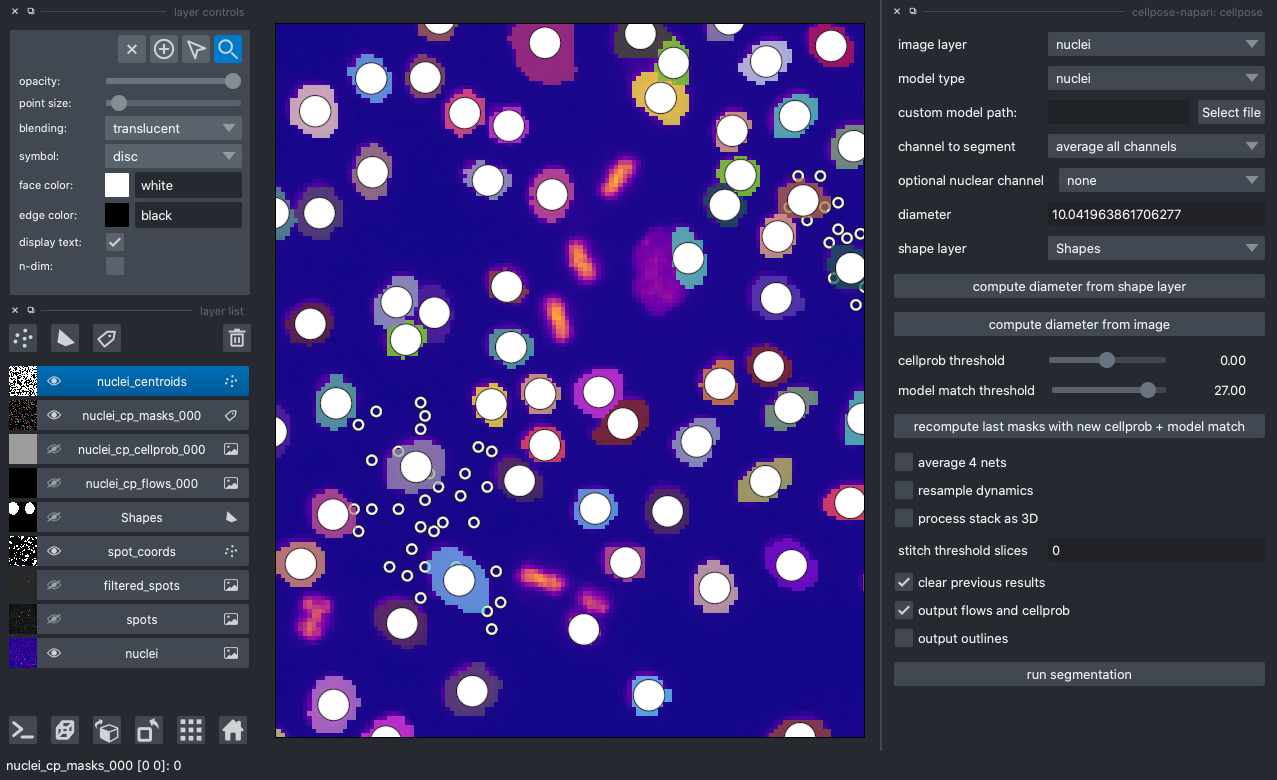

In [18]:
nbscreenshot(viewer)

### Step 2: Find the nearest nucleus for each spot

In this step, we will use a KDTree to quickly determine which nucleus (`nuclei_centroids`) each spot (`spot_coords`) is closest to. For more information on the scipy cKDTree, please see [the docs](https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.cKDTree.html) and [query examples](https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.cKDTree.query.html).

In [22]:
from scipy.spatial import cKDTree

# create the KDTree containing the nuclei locations
kdt = cKDTree(nuclei_centroids)

# query kdtree to get the nearest nucleus for each detected spot
_, nearest_nucleus_ind = kdt.query(spot_coords, k=1)

# convert the index to label value in the segmentation image
nucleus_label_values = rp_table['label']
nearest_nucleus_label = nucleus_label_values[nearest_nucleus_ind]

### Step 3: visualize the results

In this step, we will visualize how the detected spots were assigned to nuclei. To do so, we will only view the nuclei with spots and color the points to match the color of their respective nuclei.

To do so, we will make use of the properties feature of the napari Points layer. `Points.properties` is a table where each row corresponds with a point (index matched to the coordinates) and each column is a feature of that point. The properties are stored as a dictionary where each key is the name of the column and each value is a numpy array containing the values for that column. For example, if we had 3 points with properties table as shown in the table below,


| area | confidence |
| --- | --- |
| 10 | 0.1 |
| 20 | 0.5 |
| 30 | 0.9 |

we would create the properties as follows:

```python
properties = {
    'area': np.array([10, 20, 30]),
    'confidence': np.array([0.1, 0.5, 0.9])
}
```

In this case, we will create a properties table with a `nucleus_label` column, which is the label value for the nucleus to which that spot has been assigned. That is the key is `nucleus_label` and the value is `nearest_nucleus_label`, which was defined above.

In [ ]:
# create a properties table that maps each detected spot
# to a nucleus label.
spot_properties = {'nucleus_label': nearest_nucleus_label}

In [33]:
# define the color cycle as a list of RGBA colors
color_cycle = [
    [0.12156863, 0.46666667, 0.70588235, 1.],
    [1.        , 0.49803922, 0.05490196, 1.],
    [0.17254902, 0.62745098, 0.17254902, 1.],
    [0.83921569, 0.15294118, 0.15686275, 1.],
    [0.58039216, 0.40392157, 0.74117647, 1.],
    [0.54901961, 0.3372549 , 0.29411765, 1.],
    [0.89019608, 0.46666667, 0.76078431, 1.],
    [0.49803922, 0.49803922, 0.49803922, 1.],
    [0.7372549 , 0.74117647, 0.13333333, 1.],
    [0.09019608, 0.74509804, 0.81176471, 1.]
]

# define the face color options
face_color = {
    'colors': 'nucleus_label',
    'color_mode': 'cycle',
    'categorical_colormap': color_cycle
}
pts = viewer.add_points(
    spot_coords,
    properties=spot_properties,
    face_color=face_color,
    symbol='ring',
    size=4
)

In [42]:
cmap = pts._face.categorical_colormap.colormap

nuclei_labels_layer = viewer.layers['nuclei_cp_masks_000']
nuclei_labels_layer.contour = 0
nuclei_labels_layer.color = cmap

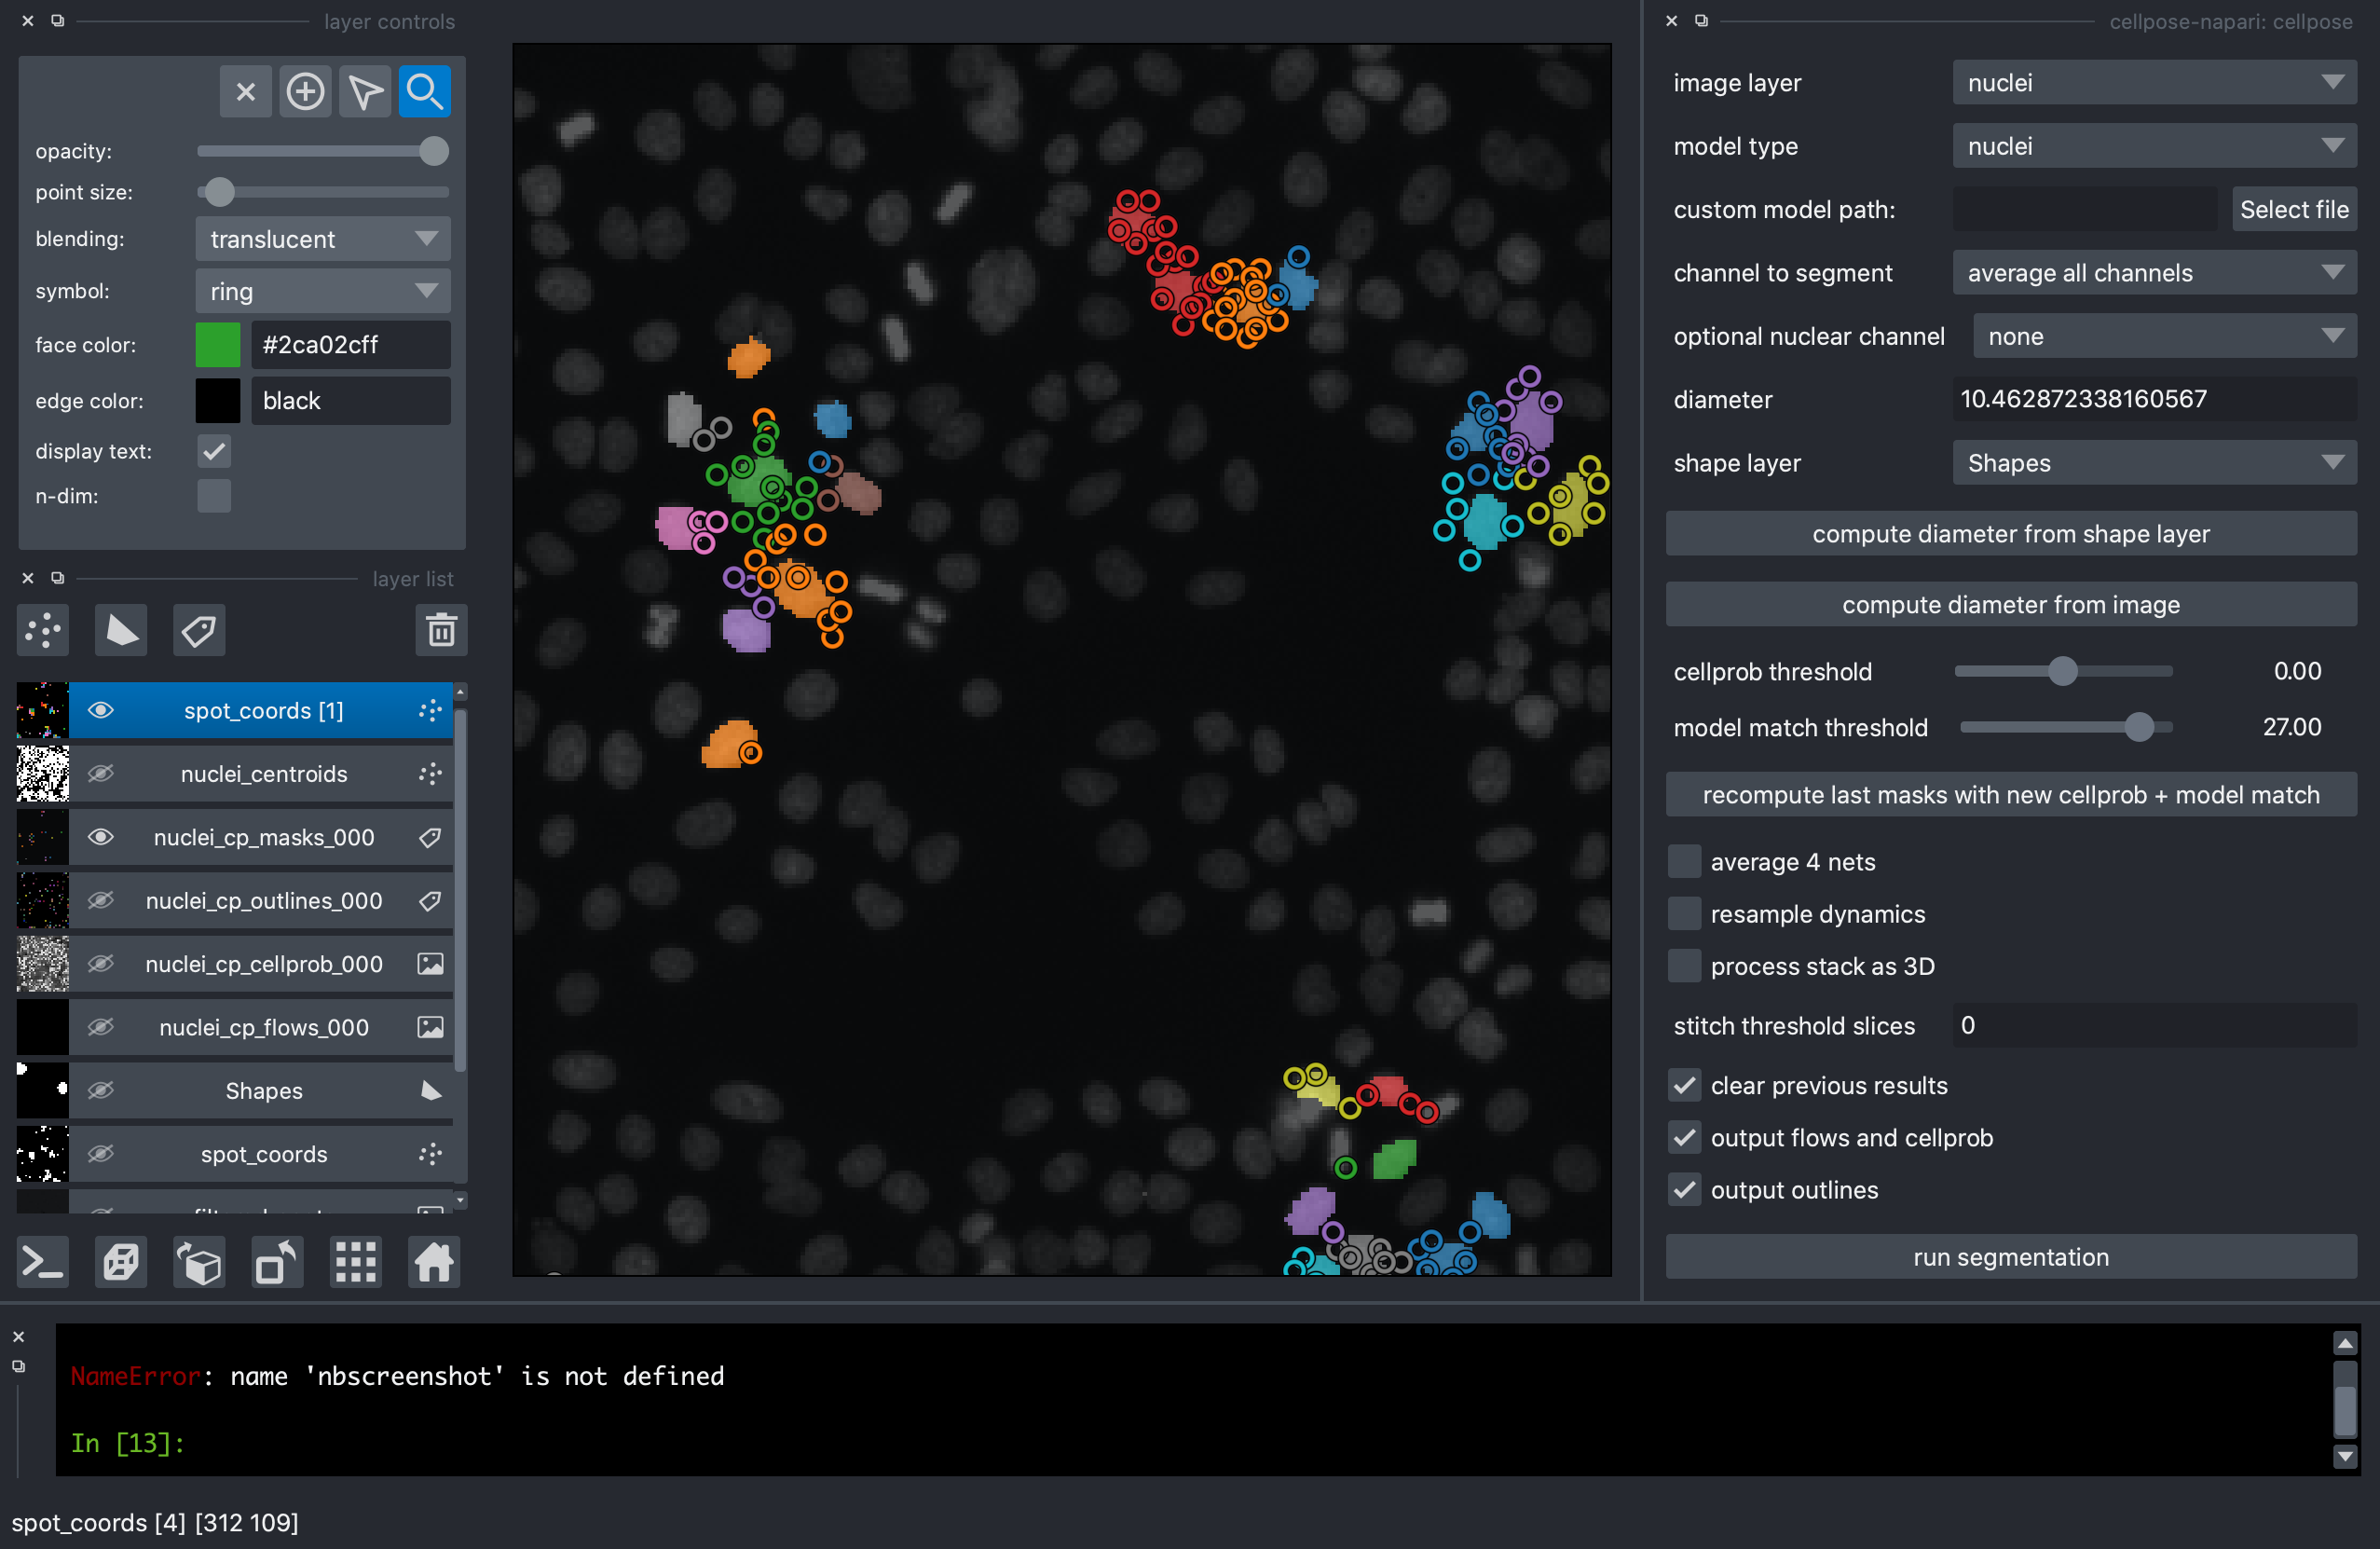

In [45]:
nbscreenshot(viewer)